In [1]:
import numpy as np
from modules import zip2array_filenames, extract_pixels, PersistentHomologyClassifier, plot_metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from itertools import product

In [2]:
# global controls
extract_data = False
extract_features = True
ppc = [(4,4), (8,8), (16,16)]
cpb = [(2,2), (3,3)]
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
cv_folds = 5

In [3]:
if extract_data:
    # ------- FILE EXTRACTION ------ 
    # Extract File Names
    breast_cancer = {'target_names': ['benign', 'malignant'], 'image_dim': (224, 224, 3)}
    classes = breast_cancer['target_names']
    zip_paths = ['BreastCancer_Benign.zip', 'BreastCancer_Malignant.zip']

    for idx, clss in enumerate(classes):
        breast_cancer[clss+'_paths'] = zip2array_filenames(zip_paths[idx], 'png')

    num_benign, num_malignant = len(breast_cancer['benign_paths']), len(breast_cancer['malignant_paths'])

    # Extract Pixels using Image File Names
    for c in classes:
        breast_cancer[c+'_pixels'] = [extract_pixels(img_path, grayscaled=True, flattened=True) for img_path in breast_cancer[c+'_paths']]

    # Organizing Data according the Pixels and Targets
    breast_cancer['data'], breast_cancer['target'] = [], []
    for idx, clss in enumerate(classes):
        new_data = [data for data in breast_cancer[clss+'_pixels']]
        new_target = [idx for _ in breast_cancer[clss+'_pixels']]

        breast_cancer['data'].extend(new_data)
        breast_cancer['target'].extend(new_target)
    
    np.save('breast_cancer_dataset.npy', breast_cancer)

else:
    # load breast_cancer dictionary into npy file
    breast_cancer = np.load('breast_cancer_dataset.npy', allow_pickle=True).item()
    classes = breast_cancer['target_names']

    for c in classes:
        breast_cancer[c+'_paths'] = breast_cancer.pop(c+'Paths')
        breast_cancer[c+'_pixels'] = breast_cancer.pop(c+'Pixels')
    
    for k in ['data', 'target']:
        breast_cancer[k] = np.array(breast_cancer[k])

print("Breast cancer data has been loaded.")

Breast cancer data has been loaded.


In [9]:
if extract_features:
    # ---------- DATA PREPARATION
    print("Preparing dataset ...")
    print()

    # reshaping data
    (HEIGHT, WIDTH) = breast_cancer['image_dim'][:2]
    X = breast_cancer['data'].reshape(-1, HEIGHT, WIDTH)
    y = breast_cancer['target']
    print(f"Data is reshaped. \n Dimension of each instance: {HEIGHT*WIDTH}")


    # data splitting    
    test_size = 0.2
    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    print(f"Data is split. \n Train/Validation size: {y_train.shape[0]} images \n Test size: {y_test.shape[0]} images \n")

    # parameters and folds
    hog_params = [{'pixels_per_cell': i[0],
                   'cells_per_block': i[1]} for i in list(product(ppc, cpb))]
    params = list(product(hog_params, scalers))
    k_folds = StratifiedKFold(n_splits=cv_folds, shuffle=True,
                                  random_state=42)
    
    # iterates every parameter combination
    param_scores = []
    for i, param in enumerate(params):
        print(f"======= Running parameter combination {i+1} =======")
        print(f'HOG: pixels_per_cell = {param[0]["pixels_per_cell"]}, cells_per_block: {param[0]["cells_per_block"]}')
        print(f'Scaler: {param[1]}')

        # 5-fold cross validation
        # divides the training set into 5 folds with stratification
        # 4 folds for training and 1 fold for validation
        val_scores, j = [], 0
        for train_idx, val_idx in k_folds.split(X_train, y_train):
            X_tr, X_v = X_train[train_idx], X_train[val_idx]
            y_tr, y_v = y_train[train_idx], y_train[val_idx]

            # feature extraction (HOG)
            print(f"\n Fold {j+1} ------------")
            print(f"\n Extracting features using HOG ...")
            X_tr = np.array([hog(img, orientations=9, 
                                 **param[0]).flatten()
                            for img in X_tr])
            X_v = np.array([hog(img, orientations=9, 
                                 **param[0]).flatten()
                            for img in X_v])
            print(f" Features extracted. \n Dimension of each instance: {X_v[0].shape[0]}")
        
            # dimension reduction
            print(f"\n Reducing dimensions using PCA ...")
            pca_model = PCA(0.95).fit(X_tr)
            X_tr, X_v = pca_model.transform(X_tr), pca_model.transform(X_v)
            print(f" Dimension reduced. \n Dimension of each instance: {X_v[0].shape[0]}")

            # data scaling
            print(f"\n Scaling the data ...")
            scaler = param[1]
            scaler.fit(X_tr)
            X_tr, X_v = scaler.transform(X_tr), scaler.transform(X_v)
            print(f" Data normalized. \n Final dimension of each instance: {X_v[0].shape[0]}")

            # validation
            print(f"\n Validating using PHCA ...")
            phca_model = PersistentHomologyClassifier()
            phca_model.fit(X_tr, y_tr)

            score = f1_score(y_v, phca_model.predict(X_v))
            # score = np.random.rand()
            val_scores.append(score)
            print(f" Validation complete. \n Validation score: {score:0.4f} \n\n")

            if j == 5:
                j = 0
            else:
                j += 1
        param_scores.append(val_scores)
    param_scores = np.array(param_scores)

Preparing dataset ...

Data is reshaped. 
 Dimension of each instance: 50176
Data is split. 
 Train/Validation size: 6105 images 
 Test size: 1527 images 

======= Running parameter combination 1 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (2, 2)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2225

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2225

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:03<00:00,  1.53s/it]


 Validation complete. 
 Validation score: 0.9564 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2213

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2213

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:36<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9496 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2224

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2224

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:26<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9590 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2236

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2236

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:32<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9584 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2220

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2220

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:36<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9463 


======= Running parameter combination 2 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (2, 2)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2225

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2225

 Validating using PHCA ...


100%|██████████| 1221/1221 [33:00<00:00,  1.62s/it]


 Validation complete. 
 Validation score: 0.9577 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2213

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2213

 Validating using PHCA ...


100%|██████████| 1221/1221 [33:03<00:00,  1.62s/it]


 Validation complete. 
 Validation score: 0.9467 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2224

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2224

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:37<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9571 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2236

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2236

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:27<00:00,  1.59s/it]


 Validation complete. 
 Validation score: 0.9574 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2220

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2220

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:48<00:00,  1.61s/it]


 Validation complete. 
 Validation score: 0.9471 


======= Running parameter combination 3 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (2, 2)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2225

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2225

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:13<00:00,  1.53s/it]


 Validation complete. 
 Validation score: 0.9557 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2213

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2213

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:25<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9509 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2224

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2224

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:16<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9602 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2236

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2236

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:15<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9557 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 108900

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2220

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2220

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:34<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9434 


======= Running parameter combination 4 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (3, 3)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2206

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2206

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:30<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9582 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2193

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2193

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:43<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9538 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2205

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2205

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:25<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9607 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2217

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2217

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:29<00:00,  1.55s/it]


 Validation complete. 
 Validation score: 0.9623 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2200

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2200

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:42<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9519 


======= Running parameter combination 5 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (3, 3)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2206

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2206

 Validating using PHCA ...


100%|██████████| 1221/1221 [33:07<00:00,  1.63s/it]


 Validation complete. 
 Validation score: 0.9583 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2193

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2193

 Validating using PHCA ...


100%|██████████| 1221/1221 [33:17<00:00,  1.64s/it]


 Validation complete. 
 Validation score: 0.9473 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2205

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2205

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:45<00:00,  1.61s/it]


 Validation complete. 
 Validation score: 0.9572 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2217

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2217

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:29<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9604 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2200

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2200

 Validating using PHCA ...


100%|██████████| 1221/1221 [33:33<00:00,  1.65s/it]


 Validation complete. 
 Validation score: 0.9466 


======= Running parameter combination 6 =======
HOG: pixels_per_cell = (4, 4), cells_per_block: (3, 3)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2206

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2206

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:23<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9485 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2193

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2193

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:43<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9533 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2205

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2205

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:23<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9582 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2217

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2217

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:22<00:00,  1.54s/it]


 Validation complete. 
 Validation score: 0.9557 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 236196

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 2200

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 2200

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:40<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9441 


======= Running parameter combination 7 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (2, 2)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1448

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1448

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:13<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9043 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1440

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1440

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:05<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.8942 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1447

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1447

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:01<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9057 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1451

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1451

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:00<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9156 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1445

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1445

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:52<00:00,  1.71s/it]


 Validation complete. 
 Validation score: 0.9091 


======= Running parameter combination 8 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (2, 2)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1448

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1448

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:08<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9159 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1440

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1440

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:54<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.8964 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1447

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1447

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:59<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9064 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1451

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1451

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:51<00:00,  1.71s/it]


 Validation complete. 
 Validation score: 0.9144 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1445

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1445

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:39<00:00,  1.70s/it]


 Validation complete. 
 Validation score: 0.9213 


======= Running parameter combination 9 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (2, 2)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1448

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1448

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:16<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9037 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1440

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1440

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:12<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.8947 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1447

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1447

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:03<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9070 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1451

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1451

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:00<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9182 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 26244

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1445

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1445

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:54<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9105 


======= Running parameter combination 10 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (3, 3)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1505

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1505

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:23<00:00,  1.74s/it]


 Validation complete. 
 Validation score: 0.9091 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1497

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1497

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:04<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.8931 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1504

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1504

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:11<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9058 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1509

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1509

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:18<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9152 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1501

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1501

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:11<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9111 


======= Running parameter combination 11 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (3, 3)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1505

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1505

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:10<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9195 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1497

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1497

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:30<00:00,  1.70s/it]


 Validation complete. 
 Validation score: 0.8953 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1504

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1504

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:04<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.9068 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1509

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1509

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:10<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9217 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1501

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1501

 Validating using PHCA ...


100%|██████████| 1221/1221 [34:27<00:00,  1.69s/it]


 Validation complete. 
 Validation score: 0.9119 


======= Running parameter combination 12 =======
HOG: pixels_per_cell = (8, 8), cells_per_block: (3, 3)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1505

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1505

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:24<00:00,  1.74s/it]


 Validation complete. 
 Validation score: 0.9103 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1497

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1497

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:02<00:00,  1.72s/it]


 Validation complete. 
 Validation score: 0.8949 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1504

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1504

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:13<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9071 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1509

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1509

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:20<00:00,  1.74s/it]


 Validation complete. 
 Validation score: 0.9166 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 54756

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 1501

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 1501

 Validating using PHCA ...


100%|██████████| 1221/1221 [35:08<00:00,  1.73s/it]


 Validation complete. 
 Validation score: 0.9089 


======= Running parameter combination 13 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (2, 2)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:06<00:00,  1.58s/it]


 Validation complete. 
 Validation score: 0.9520 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 680

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 680

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:52<00:00,  1.57s/it]


 Validation complete. 
 Validation score: 0.9342 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 682

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 682

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:27<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9555 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:35<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9440 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 681

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 681

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:11<00:00,  1.58s/it]


 Validation complete. 
 Validation score: 0.9500 


======= Running parameter combination 14 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (2, 2)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:11<00:00,  1.58s/it]


 Validation complete. 
 Validation score: 0.9513 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 680

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 680

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:48<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9395 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 682

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 682

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:31<00:00,  1.60s/it]

 Validation complete. 
 Validation score: 0.9587 



 Fold 4 ------------

 Extracting features using HOG ...


 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:16<00:00,  1.59s/it]


 Validation complete. 
 Validation score: 0.9448 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 681

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 681

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:08<00:00,  1.58s/it]


 Validation complete. 
 Validation score: 0.9527 


======= Running parameter combination 15 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (2, 2)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:01<00:00,  1.57s/it]


 Validation complete. 
 Validation score: 0.9513 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 680

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 680

 Validating using PHCA ...


100%|██████████| 1221/1221 [31:39<00:00,  1.56s/it]


 Validation complete. 
 Validation score: 0.9361 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 682

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 682

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:24<00:00,  1.59s/it]


 Validation complete. 
 Validation score: 0.9542 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 683

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 683

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:24<00:00,  1.59s/it]


 Validation complete. 
 Validation score: 0.9465 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 6084

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 681

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 681

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:06<00:00,  1.58s/it]


 Validation complete. 
 Validation score: 0.9513 


======= Running parameter combination 16 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (3, 3)
Scaler: StandardScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:32<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9540 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 711

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 711

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:26<00:00,  1.59s/it]


 Validation complete. 
 Validation score: 0.9413 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:33<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9569 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:39<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9590 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 712

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 712

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:29<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9587 


======= Running parameter combination 17 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (3, 3)
Scaler: MinMaxScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:36<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9540 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 711

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 711

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:38<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9479 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:57<00:00,  1.62s/it]


 Validation complete. 
 Validation score: 0.9638 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:55<00:00,  1.62s/it]


 Validation complete. 
 Validation score: 0.9610 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 712

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 712

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:50<00:00,  1.61s/it]


 Validation complete. 
 Validation score: 0.9600 


======= Running parameter combination 18 =======
HOG: pixels_per_cell = (16, 16), cells_per_block: (3, 3)
Scaler: RobustScaler()

 Fold 1 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:34<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9552 



 Fold 2 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 711

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 711

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:28<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9413 



 Fold 3 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:35<00:00,  1.60s/it]


 Validation complete. 
 Validation score: 0.9569 



 Fold 4 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 713

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 713

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:42<00:00,  1.61s/it]


 Validation complete. 
 Validation score: 0.9621 



 Fold 5 ------------

 Extracting features using HOG ...
 Features extracted. 
 Dimension of each instance: 11664

 Reducing dimensions using PCA ...
 Dimension reduced. 
 Dimension of each instance: 712

 Scaling the data ...
 Data normalized. 
 Final dimension of each instance: 712

 Validating using PHCA ...


100%|██████████| 1221/1221 [32:15<00:00,  1.59s/it]

 Validation complete. 
 Validation score: 0.9587 




In [10]:
np.save('param_f1scores.npy', param_scores)

In [14]:
ave_scores = np.mean(param_scores, axis=1)
best_idx = int(np.argmax(ave_scores))
params[best_idx]

({'pixels_per_cell': (4, 4), 'cells_per_block': (3, 3)}, StandardScaler())

Data is reshaped. 
 Dimension of each instance: 50176
Data is split. 
 Train/Validation size: 6105 images 
 Test size: 1527 images 

Parameters in use: ({'pixels_per_cell': (4, 4), 'cells_per_block': (3, 3)}, StandardScaler())
Extracting features using HOG ...
Features extracted. 
 Dimension of each instance: 236196
Reducing dimensions using PCA ...
Dimension reduced. 
 Dimension of each instance: 2432
Data normalized. 
 Final dimension of each instance: 2432
Starting classification --------------
The PHCA model is learning from the data ...
Model finished learning. 

The model is now predicting new data ...


100%|██████████| 1527/1527 [1:20:37<00:00,  3.17s/it]

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       504
           1       0.96      0.99      0.97      1023

    accuracy                           0.96      1527
   macro avg       0.96      0.95      0.95      1527
weighted avg       0.96      0.96      0.96      1527

Parameters in use: ({'pixels_per_cell': (16, 16), 'cells_per_block': (3, 3)}, MinMaxScaler())
Extracting features using HOG ...


ValueError: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 48 rows and 48 cols.

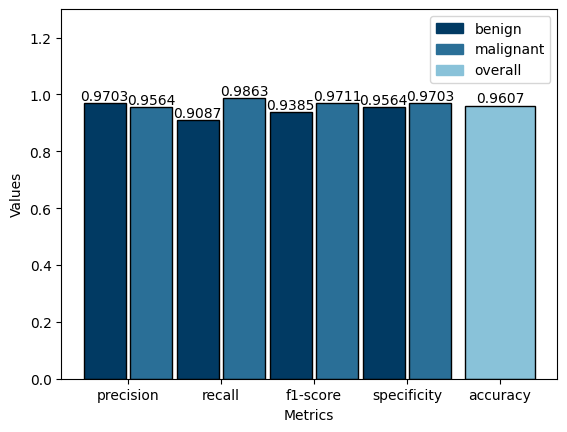

In [7]:
import time

ppc = [(4,4), (8,8), (16,16)]
cpb = [(2,2), (3,3)]
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
hog_params = [{'pixels_per_cell': i[0],
                   'cells_per_block': i[1]} for i in list(product(ppc, cpb))]
params = list(product(hog_params, scalers))

# pulling best parameters
param_scores = np.load('param_f1scores.npy')
ave_scores = np.mean(param_scores, axis=1)
best_idx = np.argsort(ave_scores)[::-1][:2]

# reshaping data
(HEIGHT, WIDTH) = breast_cancer['image_dim'][:2]
X = breast_cancer['data'].reshape(-1, HEIGHT, WIDTH)
y = breast_cancer['target']
print(f"Data is reshaped. \n Dimension of each instance: {HEIGHT*WIDTH}")

# data splitting
test_size = 0.2
indices = np.arange(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
print(f"Data is split. \n Train/Validation size: {y_train.shape[0]} images \n Test size: {y_test.shape[0]} images \n")
labels = {'true_labels': y_test}
compute_time = {'bestparam0': [], 'bestparam1': [],
                'details': ['data_prep', 'train', 'predict']}


for i, idx in enumerate(best_idx):

    start_time = time.time()
    print(f'Parameters in use: {params[idx]}')
    # feature extraction
    print("Extracting features using HOG ...")
    X_trn = np.array([hog(img, orientations=9, 
                        **params[idx][0]).flatten()
                        for img in X_train])
    X_tst = np.array([hog(img, orientations=9, 
                        **params[idx][0]).flatten()
                        for img in X_test])
    print(f"Features extracted. \n Dimension of each instance: {X_tst[0].shape[0]}")

    # dimension reduction
    print("Reducing dimensions using PCA ...")
    pca_model = PCA(0.95).fit(X_trn)
    X_trn, X_tst = pca_model.transform(X_trn), pca_model.transform(X_tst)
    print(f"Dimension reduced. \n Dimension of each instance: {X_tst[0].shape[0]}")

    # feature scaling
    scaler = params[idx][1]
    scaler.fit(X_trn)
    X_trn, X_tst = scaler.transform(X_trn), scaler.transform(X_tst)
    print(f"Data normalized. \n Final dimension of each instance: {X_tst[0].shape[0]}")
    
    # capture data preparation time
    data_prep_time = time.time()
    data_prep_duration = data_prep_time - start_time
    compute_time[f'bestparam{i}'].append(data_prep_duration)

    # training
    print('Starting classification --------------')
    print('The PHCA model is learning from the data ...')
    labels[f'phca_bestparam{i}'] = []
    phca_model = PersistentHomologyClassifier()
    phca_model.fit(X_trn, y_train)

    # capture training time
    training_time = time.time()
    training_duration = training_time - data_prep_time
    compute_time[f'bestparam{i}'].append(training_duration)
    
    # predicting
    print("Model finished learning. \n")
    print("The model is now predicting new data ...")
    labels[f'phca_bestparam{i}'].extend(phca_model.predict(X_tst))

    # capture prediction time
    predict_time = time.time()
    predict_duration = predict_time - training_time
    compute_time[f'bestparam{i}'].append(predict_duration)

    # --- classification report
    metrics = ['precision', 'recall', 'f1-score', 'specificity', 'support', 'accuracy']
    report = classification_report(labels['true_labels'], labels[f'phca_bestparam{i}'])
    print(report)
    plot_metrics(predicted_labels=labels[f'phca_bestparam{i}'],
                true_labels=labels['true_labels'],
                measurements=metrics, save=False)

In [8]:
compute_time

{'bestparam0': [1078.0335261821747, 3.3857643604278564, 4837.674439907074],
 'bestparam1': [],
 'details': ['data_prep', 'train', 'predict']}

In [19]:
np.save('report.npy', classification_report(labels['true_labels'], labels['phca'], output_dict=True))

In [20]:
np.save('predicted_labels.npy', labels)

In [22]:
X_train.shape, X_test.shape

((6105, 2432), (1527, 2432))